In [58]:
#Import all the required libraries
from transformFred import getFredData
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from datetime import datetime
from dateutil.relativedelta import relativedelta
import statsmodels.api as smodels
from sklearn.externals import joblib
import functools
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import pprint
from fbprophet import Prophet


In [59]:
#Initiate Fred Object
FredData = getFredData() #this is a class defined in transformFred.py



ac = FredData.available_codes().reset_index().set_index('Code')

#create a dictionary of macroecon variables
dict_macrovars = dict()

#initialize the start and end dates for the macroeconomic variables data pull
list_macrovars = ['HPI', 'GDP', 'MORTGAGE30US', 'UE','GS10'] #names of macroeconomic variables (MEVs)
startDate = '1980-12-25'
endDate   = '2018-12-31'

In [60]:
#Define Stationarity Tests and Diagnostics - p-Value etc.
def stationarity_test(series_data,sig_level,display):

    kpss_stats = kpss(series_data)
    adf_stats = adfuller(series_data)

    significance_threshold_kpss = kpss_stats[3][sig_level]
    significance_threshold_adf  = adf_stats[4][sig_level]
    tstat_kpss = kpss_stats[0]
    tstat_adf = adf_stats[0]

    kpss_stationarity = 0
    adf_stationarity = 0
    if tstat_kpss > significance_threshold_kpss:
        kpss_stationarity = 0
    if tstat_adf > significance_threshold_adf:
        adf_stationarity = 1
    #1 = Stationary
    if(display == True):
        print("Var:",var,"KPSS Stationarity",kpss_stationarity,"ADF Stationarity",adf_stationarity,tstat_kpss,tstat_adf)

    return kpss_stats, adf_stats

Explore the frequency of the macro variables

In [61]:
for var in list_macrovars:
    macro_df = FredData.fetch_data(var)
    macro_df =  macro_df[(macro_df.Date >= startDate) & (macro_df.Date<=endDate)]
    macro_df = macro_df.set_index('Date') #Date column now becomes the index
    print(macro_df.head(10))

USSTHPI
               HPI
Date              
1981-01-01  105.32
1981-04-01  107.44
1981-07-01  109.23
1981-10-01  109.15
1982-01-01  110.95
1982-04-01  111.90
1982-07-01  110.84
1982-10-01  112.22
1983-01-01  114.24
1983-04-01  115.43
GDP
                 GDP
Date                
1981-01-01  3124.206
1981-04-01  3162.532
1981-07-01  3260.609
1981-10-01  3280.818
1982-01-01  3274.302
1982-04-01  3331.972
1982-07-01  3366.322
1982-10-01  3402.561
1983-01-01  3473.413
1983-04-01  3578.848
MORTGAGE30US
            MORTGAGE30US
Date                    
1980-12-26         14.95
1981-01-02         14.95
1981-01-09         14.80
1981-01-16         14.85
1981-01-23         14.85
1981-01-30         15.07
1981-02-06         15.00
1981-02-13         15.03
1981-02-20         15.20
1981-02-27         15.30
UNRATE
             UE
Date           
1981-01-01  7.5
1981-02-01  7.4
1981-03-01  7.4
1981-04-01  7.2
1981-05-01  7.5
1981-06-01  7.5
1981-07-01  7.2
1981-08-01  7.4
1981-09-01  7.6
1981-10-01  

We note that, Mortgage TS is weekly,whereas GDP and HPI are quarterly and Unemployment rate is monthly; to match and merge on dates, we resample the mortgage rate on a daily time frame and then merge back on the other time series
<br>
We effect this in a four step process:
<br>
<br>
1) For loop imports MEVs into macro_df dataframe and bounds them between the dates above
<br>
2) Check for the frequency of the variables and if needed, resample such that the dates match
<br>
3) Stationarity tests (kpss and adf) are run on MEVs 
<br>
4) The MEV data and test stats are stored in dict_macrovars dictionary
<br>

The dict_macrovars persists thru the rest of the process. It is our base dictionary

In [62]:

for var in list_macrovars:
    macro_df = FredData.fetch_data(var)
    macro_df =  macro_df[(macro_df.Date >= startDate) & (macro_df.Date<=endDate)]
    macro_df = macro_df.set_index('Date') #Date column now becomes the index
    
    if var == 'MORTGAGE30US':
        macro_df = macro_df.resample('1D').interpolate(method='linear') #linearly interpolate mortgage rates

    kpss_stats, adf_stats = stationarity_test(macro_df.iloc[:,0],'5%',display=True)

    dict_macrovars[var] = {'df':macro_df,'kpss_stats':kpss_stats, 'adf_stats':adf_stats}


USSTHPI
Var: HPI KPSS Stationarity 0 ADF Stationarity 1 1.0782202326012413 0.014691418216625778
GDP
Var: GDP KPSS Stationarity 0 ADF Stationarity 1 1.117425666120897 2.7636182687438726
MORTGAGE30US
Var: MORTGAGE30US KPSS Stationarity 0 ADF Stationarity 1 27.168314651984605 -1.9678048092094471
UNRATE
Var: UE KPSS Stationarity 0 ADF Stationarity 0 0.3279890790243165 -2.947718843243514
GS10
Var: GS10 KPSS Stationarity 0 ADF Stationarity 1 2.256437500660096 -2.3139931625863017


Plot the Time Series to visually check...

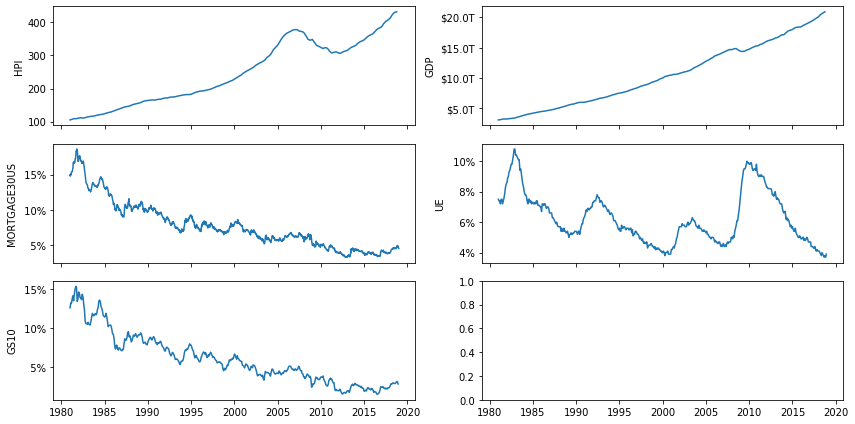

In [63]:
ncols = 2
nrows = -(-len(list_macrovars)//ncols)


fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(12, 6))
axes_list = [item for sublist in axes for item in sublist]

def trillions(x, pos):
    'The two args are the value and tick position'
    return '$%1.1fT' % (x * 1e-3)

for var in list_macrovars:
    ax = axes_list.pop(0)
    ax.plot(dict_macrovars[var]['df'])
    ax.set_ylabel(var)
    
    if var in ('UE','MORTGAGE30US','GS10'):
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

    if var in ('GDP'):
        formatter = FuncFormatter(trillions)
        ax.yaxis.set_major_formatter(formatter)
        
plt.tight_layout()

# Discuss - KPSS v/s ADF Stationarity Null

In [64]:
pprint.pprint(dict_macrovars)

{'GDP': {'adf_stats': (2.7636182687438726,
                       1.0,
                       2,
                       149,
                       {'1%': -3.4750180242954167,
                        '10%': -2.577221358046935,
                        '5%': -2.8811408028842043},
                       1556.0170805175237),
         'df':                   GDP
Date                 
1981-01-01   3124.206
1981-04-01   3162.532
1981-07-01   3260.609
1981-10-01   3280.818
1982-01-01   3274.302
1982-04-01   3331.972
1982-07-01   3366.322
1982-10-01   3402.561
1983-01-01   3473.413
1983-04-01   3578.848
1983-07-01   3689.179
1983-10-01   3794.706
1984-01-01   3908.054
1984-04-01   4009.601
1984-07-01   4084.250
1984-10-01   4148.551
1985-01-01   4230.168
1985-04-01   4294.887
1985-07-01   4386.773
1985-10-01   4444.094
1986-01-01   4507.894
1986-04-01   4545.340
1986-07-01   4607.669
1986-10-01   4657.627
1987-01-01   4722.156
1987-04-01   4806.160
1987-07-01   4884.555
1987-10-01   5007.994
19

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

Step above shows that HPI, GDP and Mortgage rates are non stationary; from literature we know log transform of macrovariables that represent levels are made stationary via a log difference transform, whereas a differencing works for absolute rates. Hence, for HPI and GDP variables and apply a log-difference and we difference the 30 Year Mortgage Rate time series and the unemployment rate where we observed conflicting results with the KPSS and ADF tests

In [65]:
for var in list_macrovars:
    if var in ('HPI','GDP'):
        df = np.log(dict_macrovars[var]['df']).diff().dropna()
        df = df.rename(columns={df.columns[0]: f'{var}_logDiff'})
        dict_macrovars[f'{var}_logDiff'] = {'df':df}
    elif var in ('MORTGAGE30US','UE','GS10'):
        df = (dict_macrovars[var]['df']).diff().dropna()
        df = df.rename(columns={df.columns[0]: f'{var}_Diff'})
        dict_macrovars[f'{var}_Diff'] = {'df':df}
    else:
        pass

We now check for stationarity of the transformed variables

In [66]:
pprint.pprint(dict_macrovars)

{'GDP': {'adf_stats': (2.7636182687438726,
                       1.0,
                       2,
                       149,
                       {'1%': -3.4750180242954167,
                        '10%': -2.577221358046935,
                        '5%': -2.8811408028842043},
                       1556.0170805175237),
         'df':                   GDP
Date                 
1981-01-01   3124.206
1981-04-01   3162.532
1981-07-01   3260.609
1981-10-01   3280.818
1982-01-01   3274.302
1982-04-01   3331.972
1982-07-01   3366.322
1982-10-01   3402.561
1983-01-01   3473.413
1983-04-01   3578.848
1983-07-01   3689.179
1983-10-01   3794.706
1984-01-01   3908.054
1984-04-01   4009.601
1984-07-01   4084.250
1984-10-01   4148.551
1985-01-01   4230.168
1985-04-01   4294.887
1985-07-01   4386.773
1985-10-01   4444.094
1986-01-01   4507.894
1986-04-01   4545.340
1986-07-01   4607.669
1986-10-01   4657.627
1987-01-01   4722.156
1987-04-01   4806.160
1987-07-01   4884.555
1987-10-01   5007.994
19

In [67]:
stationary_vars = ['HPI_logDiff', 'GDP_logDiff', 'MORTGAGE30US_Diff','UE_Diff','GS10_Diff']
for var in stationary_vars:
    kpss_stats, adf_stats = stationarity_test(dict_macrovars[var]['df'].iloc[:,0],'5%',display=True)
    dict_macrovars[var] = {'df': dict_macrovars[var]['df'], 'kpss_stats':kpss_stats, 'adf_stats':adf_stats}

Var: HPI_logDiff KPSS Stationarity 0 ADF Stationarity 0 0.10071975553969015 -3.237862153349767
Var: GDP_logDiff KPSS Stationarity 0 ADF Stationarity 0 0.6534662524159232 -5.106099333312635
Var: MORTGAGE30US_Diff KPSS Stationarity 0 ADF Stationarity 0 0.15700100786340923 -14.86568726892273
Var: UE_Diff KPSS Stationarity 0 ADF Stationarity 0 0.06549176303019473 -4.312643882192725
Var: GS10_Diff KPSS Stationarity 0 ADF Stationarity 0 0.09680413183607783 -6.625798705182152


Population of the dataframe with variables used in analysis
<br>
This for loop populates the dataframe from the dictionary dict_macrovars

In [68]:
df_all = pd.DataFrame(index=['Date'])#dataframe of MEVs is now constructed
df_all.dropna(inplace=True)

for mev_name, mev_dict in dict_macrovars.items():
    df = mev_dict['df'].copy()
    df_all = df_all.join(df, how='outer')
    #print(df.head(5))
    #print(df_all.head(5))

df_wide = df_all.dropna()
print(df_wide.head(5))

                        HPI       GDP  MORTGAGE30US   UE   GS10  HPI_logDiff  \
1981-04-01 00:00:00  107.44  3162.532     15.400000  7.2  13.68     0.019929   
1981-07-01 00:00:00  109.23  3260.609     16.634286  7.2  14.28     0.016523   
1981-10-01 00:00:00  109.15  3280.818     18.291429  7.9  15.15    -0.000733   
1982-01-01 00:00:00  110.95  3274.302     17.072500  8.6  14.59     0.016357   
1982-04-01 00:00:00  111.90  3331.972     16.962857  9.3  13.87     0.008526   

                     GDP_logDiff  MORTGAGE30US_Diff  UE_Diff  GS10_Diff  
1981-04-01 00:00:00     0.012193           0.000000     -0.2       0.56  
1981-07-01 00:00:00     0.030541           0.002857     -0.3       0.81  
1981-10-01 00:00:00     0.006179          -0.011429      0.3      -0.17  
1982-01-01 00:00:00    -0.001988           0.032500      0.1       0.87  
1982-04-01 00:00:00     0.017460          -0.012857      0.3       0.01  


In [69]:
df_wide.head()

,HPI,GDP,MORTGAGE30US,UE,GS10,HPI_logDiff,GDP_logDiff,MORTGAGE30US_Diff,UE_Diff,GS10_Diff
1981-04-01 00:00:00,107.44,3162.532,15.400000,7.2,13.68,0.019929,0.012193,0.000000,-0.2,0.56
1981-07-01 00:00:00,109.23,3260.609,16.634286,7.2,14.28,0.016523,0.030541,0.002857,-0.3,0.81
1981-10-01 00:00:00,109.15,3280.818,18.291429,7.9,15.15,-0.000733,0.006179,-0.011429,0.3,-0.17
1982-01-01 00:00:00,110.95,3274.302,17.072500,8.6,14.59,0.016357,-0.001988,0.032500,0.1,0.87
1982-04-01 00:00:00,111.90,3331.972,16.962857,9.3,13.87,0.008526,0.017460,-0.012857,0.3,0.01


In [70]:
for mev_name, mev_dict in dict_macrovars.items():
    print(mev_name)

HPI
GDP
MORTGAGE30US
UE
GS10
HPI_logDiff
GDP_logDiff
MORTGAGE30US_Diff
UE_Diff
GS10_Diff


In [71]:
pprint.pprint(df_wide)

               HPI        GDP  MORTGAGE30US    UE   GS10  HPI_logDiff  \
1981-04-01  107.44   3162.532     15.400000   7.2  13.68     0.019929   
1981-07-01  109.23   3260.609     16.634286   7.2  14.28     0.016523   
1981-10-01  109.15   3280.818     18.291429   7.9  15.15    -0.000733   
1982-01-01  110.95   3274.302     17.072500   8.6  14.59     0.016357   
1982-04-01  111.90   3331.972     16.962857   9.3  13.87     0.008526   
1982-07-01  110.84   3366.322     16.850000   9.8  13.95    -0.009518   
1982-10-01  112.22   3402.561     15.130000  10.4  10.91     0.012374   
1983-01-01  114.24   3473.413     13.554286  10.4  10.46     0.017840   
1983-04-01  115.43   3578.848     12.820000  10.2  10.40     0.010363   
1983-07-01  116.40   3689.179     13.080000   9.4  11.38     0.008368   
1983-10-01  117.06   3794.706     13.641429   8.8  11.54     0.005654   
1984-01-01  118.82   3908.054     13.430000   8.0  11.67     0.014923   
1984-04-01  120.37   4009.601     13.572857   7.7  

<hr style="height:2px;border:none;color:#333;background-color:#333;" />

Pivot the a data frame above to create a wide dataframe


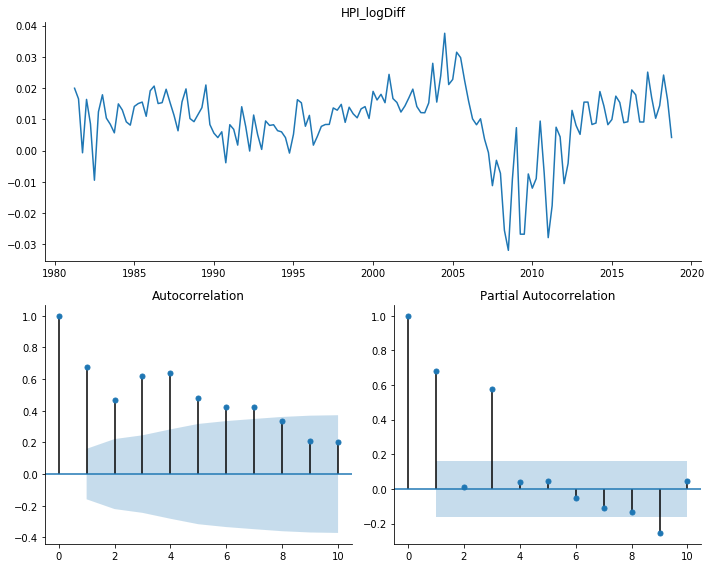

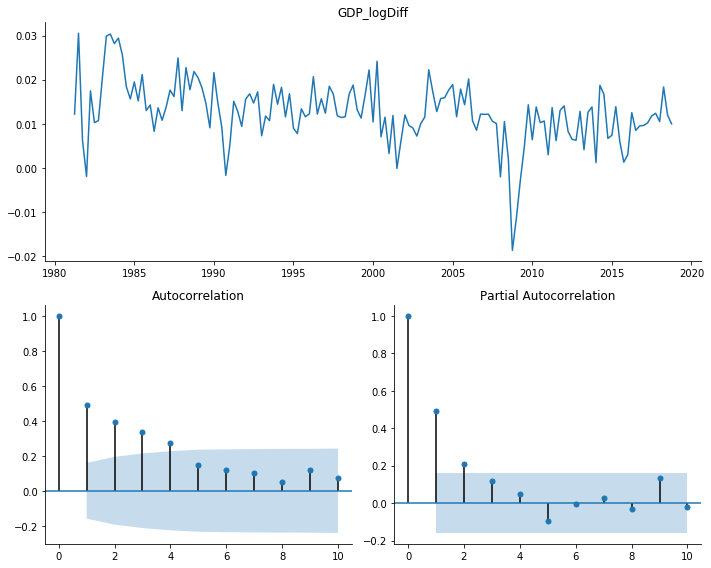

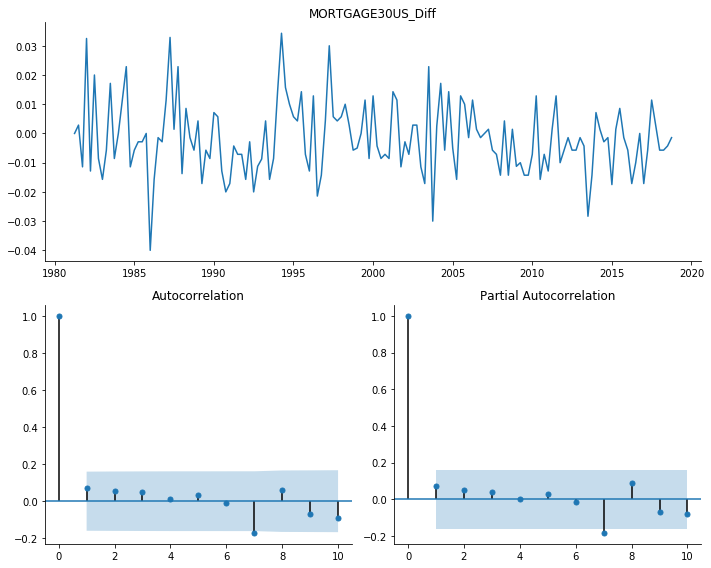

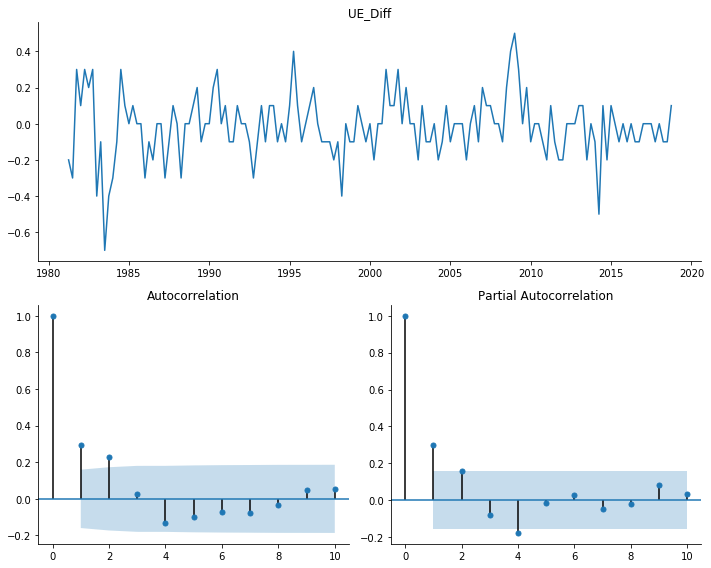

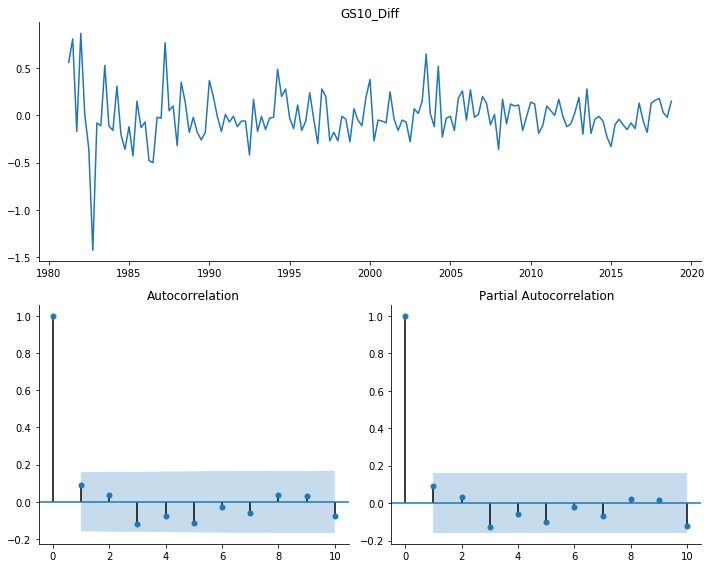

In [72]:
#This function plots the PAC, ACF
def tsplot(y, x, lags=None, figsize=(10, 8)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    ts_ax.set_title(x)

    ts_ax.plot(y.index,y.values)
    #y.plot(ax=ts_ax)
    smodels.graphics.tsa.plot_acf(y, alpha = 0.05, use_vlines= True,lags=10, ax=acf_ax)
    smodels.graphics.tsa.plot_pacf(y, alpha = 0.05, use_vlines= True, lags=10, ax=pacf_ax)
    #[ax.set_xlim(0.5) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

#ACF,PACF plotting function is called in a loop run on all model variables 
for var in stationary_vars:
    tsplot(df_wide[var],var)

#plt.plot(df_wide['HPI_logDiff'].index,df_wide['HPI_logDiff'].values)

# Part A
<br>
<br>PACF Plots suggest a max lag of 4
<br>
<br>
We now construct the Vector Auto Regression models for the macro variables


In [125]:
varModelDF = df_wide[stationary_vars]#limit dataframe to only those stationary variables that will be use VAR model

#Run Model on test-train
list_vars = varModelDF.columns

lags = range(1, 5)
varModelDF = varModelDF.assign(**{
    '{}_{}'.format(col, t): varModelDF[col].shift(t)
    for t in lags
    for col in varModelDF
})

varModelDF.dropna(inplace=True) #VarModelDF will have lagged variables that have NaN - deleting those will start the time series from 1982

#test-train split etc.
startDate_train = datetime.strptime('1981-07-01', '%Y-%m-%d') #data start date parsed to required format
endDate_train = datetime.strptime('2012-07-01', '%Y-%m-%d')#train end date parsed to required format


dates_list = varModelDF.index #contains all dates

train_dates = [date for date in dates_list if (date >= startDate_train) & (date <= endDate_train)]

#all dates btwn start and end train are selected
test_dates = list(set(dates_list) - set(train_dates)) #dates selected from train are removed from total & alloc to test
test_dates.sort()

last_actual_data = (df_wide.loc[[endDate_train,]])#In order to transform the VAR model results back to levels, we need the last actuals

train_ModelDF = varModelDF.loc[train_dates]#form train dataframe using only train dates
test_ModelDF = varModelDF.loc[test_dates]#form test dataframe using only test dates


#var_model_list.append('UE')
#varModelDF = df_wide[var_model_list]
#varModelDF.dropna(inplace=True)

model = VAR(train_ModelDF[list_vars])

bic_results = model.fit(ic='bic',maxlags =4)


In [126]:
bic_results.summary() #for all variables, BIC ended up selecting L1 models


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2019
Time:                     16:20:29
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -34.7983
Nobs:                     121.000    HQIC:                  -35.2100
Log likelihood:           1318.78    FPE:                3.85843e-16
AIC:                     -35.4915    Det(Omega_mle):     3.02914e-16
--------------------------------------------------------------------
Results for equation HPI_logDiff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000972         0.001796            0.541           0.588
L1.HPI_logDiff               0.657971         0.068039            9.670           0.000
L1.GDP_logDiff            

Based on BIC, the VAR model picks up only one lag. We want to benchmark this VAR Model with an OLS construct with a deeper lag structure; Hence we reran the VAR with maxlags = 4 to explore the relationshop. Given that the data is at quarterly frequency we do not see any reason for going beyond four lags for these macroeconomic variables.

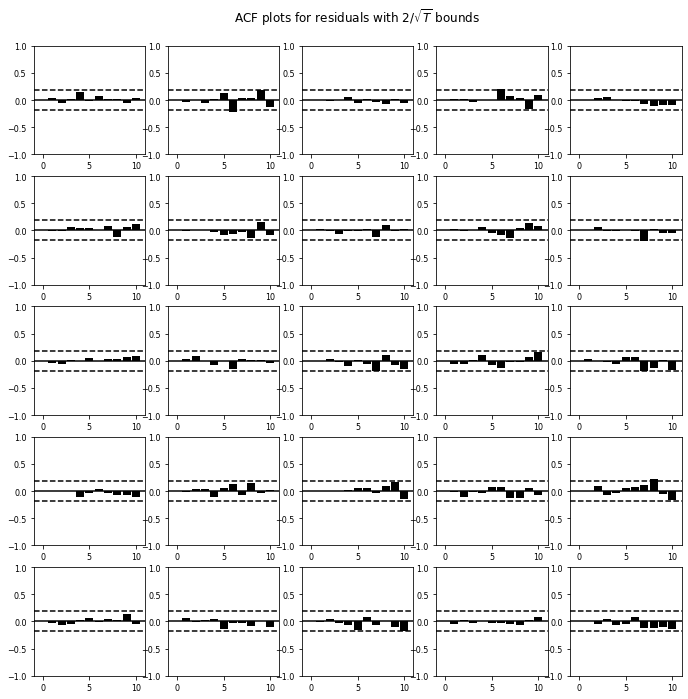

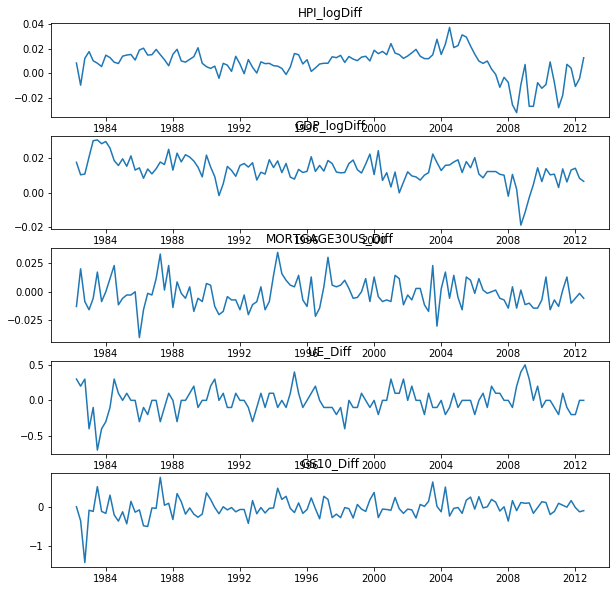

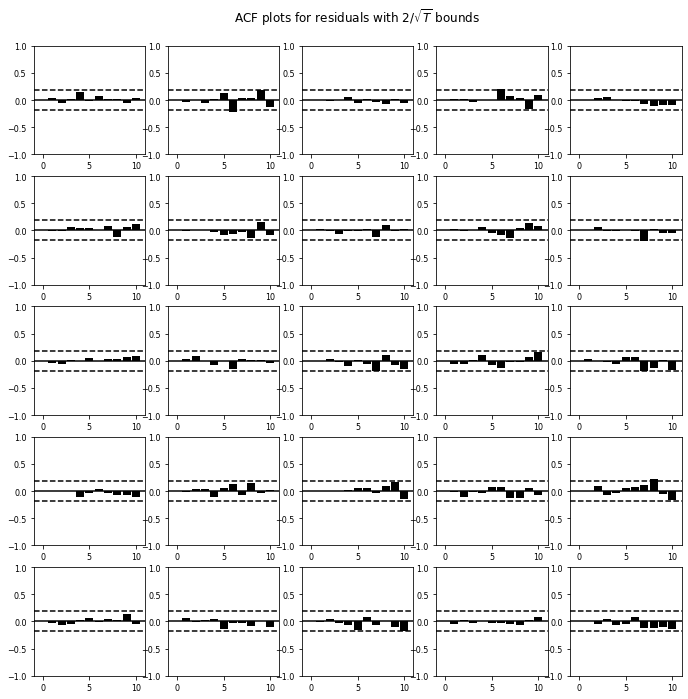

In [75]:
lag4_results = model.fit(maxlags =4)

lag4_results.plot()
lag4_results.plot_acorr()



In [76]:
lag4_results.summary() 

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2019
Time:                     15:21:55
--------------------------------------------------------------------
No. of Equations:         5.00000    BIC:                   -33.1407
Nobs:                     118.000    HQIC:                  -34.6051
Log likelihood:           1368.59    FPE:                3.50552e-16
AIC:                     -35.6062    Det(Omega_mle):     1.54557e-16
--------------------------------------------------------------------
Results for equation HPI_logDiff
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
const                        0.000792         0.002294            0.345           0.730
L1.HPI_logDiff               0.677355         0.098675            6.865           0.000
L1.GDP_logDiff            

# Part B

We now run the OLS regression based models

In [127]:
#OLS Models
ols_err = []

startDate_train = datetime.strptime('1981-07-01', '%Y-%m-%d') #data start date parsed to required format
endDate_train = datetime.strptime('2012-07-01', '%Y-%m-%d')#train end date parsed to required form

#HPI Model
#train_ModelDF = varModelDF.loc[sta]#form train dataframe using only train dates
#test_ModelDF = varModelDF.loc[test_dates]#form test dataframe using only test dates


var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['HPI_logDiff'], X)

hpiOLS = model.fit()
hpiOLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            HPI_logDiff   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     72.41
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           1.24e-26
Time:                        16:20:36   Log-Likelihood:                 432.69
No. Observations:                 122   AIC:                            -857.4
Df Residuals:                     118   BIC:                            -846.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      1.138      0.257      -0.001       0.003
HPI_logDiff_1     0.6754      0.078      8.688      0.000       0.521       0.829
HPI_logDiff_2    -0.3391      0.093     -3.647      0.000      -0.523      -0.155
HPI_logDiff_3     0.5327      0.077      6.878      0.000       0.379       0.686
==============================================================================
Omnibus:                        1.380   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.502   Jarque-Bera (JB):                1.110
Skew:                          -0.232   Prob(JB):                        0.574
Kurtosis:                       3.061   Cond. No.                         178.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
#GDP Model
var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['GDP_logDiff'], X)

gdpOLS = model.fit()
gdpOLS.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GDP_logDiff   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     26.60
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           3.25e-13
Time:                        15:21:55   Log-Likelihood:                 460.89
No. Observations:                 122   AIC:                            -913.8
Df Residuals:                     118   BIC:                            -902.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0046      0.001      3.975      0.000       0.002       0.007
HPI_logDiff_1     0.1426      0.047      3.044      0.003       0.050       0.235
GDP_logDiff_1     0.3566      0.086      4.149      0.000       0.186       0.527
GDP_logDiff_2     0.2053      0.086      2.387      0.019       0.035       0.376
==============================================================================
Omnibus:                        8.100   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.017   Jarque-Bera (JB):               10.645
Skew:                          -0.355   Prob(JB):                      0.00488
Kurtosis:                       4.261   Cond. No.                         207.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:

#Mort Model
var = ['GS10_Diff']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['MORTGAGE30US_Diff'], X)

mortOLS = model.fit()
mortOLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      MORTGAGE30US_Diff   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     33.74
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           5.28e-08
Time:                        15:21:55   Log-Likelihood:                 376.94
No. Observations:                 122   AIC:                            -749.9
Df Residuals:                     120   BIC:                            -744.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0010      0.001     -1.010      0.315      -0.003       0.001
GS10_Diff      0.0231      0.004      5.809      0.000       0.015       0.031
==============================================================================
Omnibus:                        3.565   Durbin-Watson:                   1.747
Prob(Omnibus):                  0.168   Jarque-Bera (JB):                4.008
Skew:                           0.074   Prob(JB):                        0.135
Kurtosis:                       3.876   Cond. No.                         3.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:


#UE Model
var = ['UE_Diff_1','GS10_Diff_1']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['UE_Diff'], X)

ueOLS = model.fit()
ueOLS.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                UE_Diff   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     15.85
Date:                Mon, 24 Jun 2019   Prob (F-statistic):           7.87e-07
Time:                        15:21:55   Log-Likelihood:                 53.041
No. Observations:                 122   AIC:                            -100.1
Df Residuals:                     119   BIC:                            -91.67
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0028      0.014     -0.195      0.846      -0.031       0.026
UE_Diff_1       0.4159      0.083      5.026      0.000       0.252       0.580
GS10_Diff_1     0.1888      0.055      3.425      0.001       0.080       0.298
==============================================================================
Omnibus:                        7.124   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                9.069
Skew:                          -0.316   Prob(JB):                       0.0107
Kurtosis:                       4.177   Cond. No.                         5.84
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [81]:
#Treasury Model
var = ['HPI_logDiff_3','HPI_logDiff_4']
X = smodels.add_constant(train_ModelDF[var])
model = smodels.OLS(train_ModelDF['GS10_Diff'], X)

gs10OLS = model.fit()
gs10OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              GS10_Diff   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     2.119
Date:                Mon, 24 Jun 2019   Prob (F-statistic):              0.125
Time:                        15:21:55   Log-Likelihood:                -3.1683
No. Observations:                 122   AIC:                             12.34
Df Residuals:                     119   BIC:                             20.75
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0234      0.029     -0.796      0.427      -0.082       0.035
HPI_logDiff_3    -5.0770      2.759     -1.840      0.068     -10.541       0.387
HPI_logDiff_4     5.3690      2.751      1.952      0.053      -0.077      10.815
==============================================================================
Omnibus:                       33.838   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.923
Skew:                          -0.679   Prob(JB):                     1.17e-45
Kurtosis:                       9.234   Cond. No.                         158.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Part C

We will now try the Facebook Prophet algorithm

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0       3285.662050
1       3372.794746
2       3461.050643
3       3533.529651
4       3576.262024
5       3674.185928
6       3794.377323
7       3876.100809
8       3985.280956
9       4049.596079
10      4074.066650
11      4128.919217
12      4275.016435
13      4350.941144
14      4407.280356
15      4470.797665
16      4565.167838
17      4652.300534
18      4740.556431
19      4813.035440
20      4855.827529
21      4953.811814
22      5074.064252
23      5155.848781
24      5265.196178
25      5329.678549
26      5354.318207
27      5409.339862
28      5555.602491
29      5631.694448
           ...     
100    14029.303830
101    14137.979551
102    14269.040913
103    14361.634366
104    14481.566330
105    14556.633269
106    14591.973808
107    14657.696344
108    14814.427226
109    14901.103751
110    14968.312931
111    15042.700209
112    15147.704045
113    15245.588557
114    15344.714422
115    15428.063398
116    15481.429435
117    15590.105155
118    15721.166518


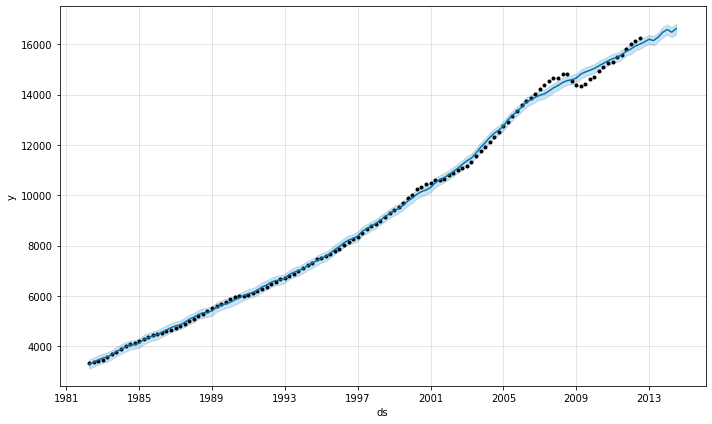

In [82]:
prophet = Prophet(yearly_seasonality = True, seasonality_prior_scale=0.1)
timeSeries = pd.DataFrame()
timeSeries['ds'] = df_wide.loc[train_dates].index
timeSeries['y'] = df_wide.loc[train_dates].GDP.values
prophet.fit(timeSeries)
future = prophet.make_future_dataframe(periods=8, freq='Q')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)

hpiFB = forecast['yhat']
hpiFB


# Forecast and transform back to original levels

Define Mean Absolute Error - the error metric we'll use for checking model errors.

In [83]:
#Define MAE
def mae(ypred, ytrue):
    """ returns the mean absolute percentage error """
    return np.mean(np.abs(ypred-ytrue))

In [84]:
#test performance
startDt = test_dates[0]
endDt = test_dates[-1]

#lag_order = results.k_ar
lag_order = 1
#Number of forecast periods - we will change this later
fcst_period = len(test_ModelDF)
#train_varModelDF.values[-lag_order:]
fcst_var = bic_results.forecast(train_ModelDF[list_vars].values[-lag_order:], fcst_period)

Given that the WSJ forecast is available for 2 years (8 periods and not 25 as shown in code above), forecast will be used in conjunction with WSJ forecast for the same timeframe. We test the MAE on a longer time period.

In [85]:
def to_levels(dataframe, last_vals):
    df = dataframe.copy()
    for col in df.columns:
        if('_Diff' in col):
            df[col] = np.cumsum(df[col]) + last_vals[col[:-5]][0]
        elif('_logDiff' in col):
            df[col] = np.exp(np.cumsum(df[col])) * last_vals[col[:-8]][0]
        else:
            raise KeyError
    return df

In [86]:
forecastVar = pd.DataFrame(fcst_var).copy()
forecastVar.columns = list_vars

varModelfcst = to_levels(forecastVar, last_actual_data)
varModelfcst.columns = list_macrovars

In [87]:
forecast_dates = pd.date_range(last_actual_data.index[0], periods=fcst_period+1, freq='3MS')[1:]
varModelfcst.index = forecast_dates
varModelfcst

,HPI,GDP,MORTGAGE30US,UE,GS10
2012-10-01,313.615699,16437.202032,3.641065,8.203183,1.541764
2013-01-01,316.436521,16639.081837,3.639822,8.208850,1.536991
2013-04-01,319.162110,16850.288407,3.638492,8.208435,1.521701
2013-07-01,321.869395,17067.569132,3.637096,8.203084,1.503324
2013-10-01,324.586220,17289.544190,3.635679,8.195035,1.484086
2014-01-01,327.324170,17515.483747,3.634259,8.185600,1.464537
2014-04-01,330.088109,17745.011149,3.632842,8.175422,1.444855
2014-07-01,332.879814,17977.943207,3.631429,8.164813,1.425121
2014-10-01,335.699686,18214.197161,3.630021,8.153937,1.405373
2015-01-01,338.547570,18453.741999,3.628616,8.142884,1.385627


In [88]:
maeVar = mae(varModelfcst, df_wide.loc[forecast_dates, list_macrovars])

In [89]:
var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
X = smodels.add_constant(test_ModelDF[var])
olsfcstHPI  = pd.DataFrame(hpiOLS.predict(X))

var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
X = smodels.add_constant(test_ModelDF[var])
olsfcstGDP  = pd.DataFrame(gdpOLS.predict(X))

var = ['GS10_Diff']
X = smodels.add_constant(test_ModelDF[var])
olsfcstMort = pd.DataFrame(mortOLS.predict(X))

var = ['UE_Diff_1','GS10_Diff_1']
X = smodels.add_constant(test_ModelDF[var])
olsfcstUE   = pd.DataFrame(ueOLS.predict(X))

var = ['HPI_logDiff_3','HPI_logDiff_4']
X = smodels.add_constant(test_ModelDF[var])
olsfcstGS   = pd.DataFrame(gs10OLS.predict(X))


In [90]:
forecastOLS = pd.concat([olsfcstHPI,olsfcstGDP,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
forecastOLS.columns = list_vars
olsModelfcst = to_levels(forecastOLS, last_actual_data)
olsModelfcst.columns = list_macrovars

In [91]:
olsModelfcst

,HPI,GDP,MORTGAGE30US,UE,GS10
2012-10-01,312.145301,16427.424569,3.642532,8.180199,1.583952
2013-01-01,312.088434,16580.683146,3.645905,8.183057,1.524637
2013-04-01,314.771869,16766.937305,3.640265,8.257716,1.413871
2013-07-01,319.189628,16950.582641,3.645717,8.258736,1.418682
2013-10-01,322.050078,17157.517711,3.640308,8.225617,1.412138
2014-01-01,325.146229,17387.019357,3.638365,8.186934,1.337837
2014-04-01,329.180181,17545.840822,3.637116,8.134984,1.318914
2014-07-01,334.206250,17796.536283,3.634711,7.922336,1.336502
2014-10-01,337.190043,18091.418141,3.628378,7.949790,1.313117
2015-01-01,341.173770,18302.181527,3.619734,7.820374,1.241105


In [92]:
maeOLS = mae(olsModelfcst.loc[forecast_dates], df_wide.loc[forecast_dates, list_macrovars])

In [93]:
print("MAE - Var and OLS models")
print(maeVar)
print(maeOLS)

MAE - Var and OLS models
HPI              18.867390
GDP             833.245052
MORTGAGE30US      0.453393
UE                2.636659
GS10              0.966688
dtype: float64
HPI               9.328267
GDP             508.622974
MORTGAGE30US      0.458765
UE                2.322318
GS10              1.068527
dtype: float64


# Plot the various model forecasts v/s actuals

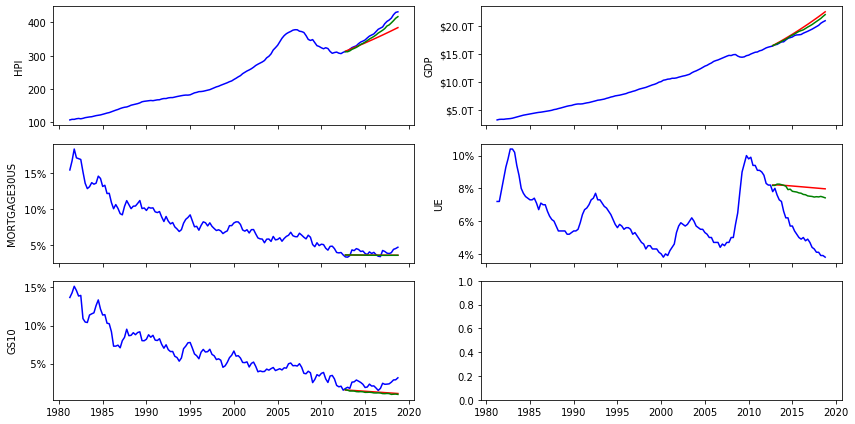

In [94]:
ncols = 2
nrows = -(-len(list_macrovars)//ncols)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=False, figsize=(12, 6))
axes_list = [item for sublist in axes for item in sublist]

for var in list_macrovars:
    ax = axes_list.pop(0)
    ax.plot(df_wide[var],color='blue')
    ax.plot(varModelfcst[var],color='red')
    ax.plot(olsModelfcst[var],color='green')
    ax.set_ylabel(var)
    
    if var in ('UE','MORTGAGE30US','GS10'):
        vals = ax.get_yticks()
        ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])

    if var in ('GDP'):
        formatter = FuncFormatter(trillions)
        ax.yaxis.set_major_formatter(formatter)
        
plt.tight_layout()

From the above it's clear we want to use OLS models; We will build out a rolling-period forecast. How this works is, essentially, we will use a training window, forcast out the next 8 quarters of the macro variable; move the training window out by one quarter and generate a new 8 period forecast

# Rolling Forecast

In [131]:
#test-train split etc.
startDate_train = datetime.strptime('1982-04-01', '%Y-%m-%d') #data start date parsed to required format
last_forecast_date = datetime.strptime('2018-10-01', '%Y-%m-%d') + relativedelta(months=-24)  #data start date parsed to required format; Here the rationale is to use in the second step weighting which is contingent on the 24 month period.
fcst_start = datetime.strptime('2011-07-01', '%Y-%m-%d')#This date corresponds to first WSJ 50 economist survey start date

olsModelfcsts = pd.DataFrame() 

while(fcst_start<=last_forecast_date):
    fcst_end = fcst_start + relativedelta(months=24)#8 Qtr forecast

    dates_list = varModelDF.index #contains all dates
    last_actual_data = (df_wide.loc[[fcst_start,]])#In order to transform the model results back to levels, we need the last actuals

    train_dates = [date for date in dates_list if (date >= startDate_train) & (date < fcst_start)]
    fcst_dates = [date for date in dates_list if (date >= fcst_start) & (date <= fcst_end)]

    train_ModelDF = varModelDF.loc[train_dates]#form train dataframe using only train dates
    fcst_ModelDF = varModelDF.loc[fcst_dates]#form test dataframe using only test dates

    #HPI
    var = ['HPI_logDiff_1','HPI_logDiff_2','HPI_logDiff_3']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['HPI_logDiff']
    model = smodels.OLS(y, X)
    hpiOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstHPI  = pd.DataFrame(hpiOLS.predict(X))


    #GDP
    var = ['HPI_logDiff_1','GDP_logDiff_1','GDP_logDiff_2']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['GDP_logDiff']
    model = smodels.OLS(y, X)
    gdpOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstGDP  = pd.DataFrame(gdpOLS.predict(X))

    #UE
    var = ['UE_Diff_1','GS10_Diff_1']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['UE_Diff']
    model = smodels.OLS(y, X)
    ueOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstUE  = pd.DataFrame(ueOLS.predict(X))

    #MORTGAGE RATE
    var = ['GS10_Diff']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['MORTGAGE30US_Diff']
    model = smodels.OLS(y, X)
    mortOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstMort  = pd.DataFrame(mortOLS.predict(X))


    #Treasury
    var = ['HPI_logDiff_3','HPI_logDiff_4']
    X = smodels.add_constant(train_ModelDF[var])
    y = train_ModelDF['GS10_Diff']
    model = smodels.OLS(y, X)
    gsOLS = model.fit()
    X = smodels.add_constant(fcst_ModelDF[var])
    olsfcstGS  = pd.DataFrame(gsOLS.predict(X))

    forecastOLS = pd.concat([olsfcstHPI,olsfcstGDP,olsfcstMort,olsfcstUE,olsfcstGS],axis = 1)
    forecastOLS.columns = list_vars
    olsModelfcst = to_levels(forecastOLS, last_actual_data)
    olsModelfcst.reset_index(inplace=True)
    olsModelfcst.columns = ['ForcastDt'] + list_macrovars
    olsModelfcst['ModelDt'] = fcst_start - relativedelta(months=3)
    cols = olsModelfcst.columns.to_list()
    cols = cols[-1:] + cols[:-1]
    olsModelfcst = olsModelfcst[cols]
    olsModelfcsts = olsModelfcsts.append(olsModelfcst)
    
    
    fcst_start = fcst_start + relativedelta(months=3)

In [132]:
olsModelfcsts

,ModelDt,ForcastDt,HPI,GDP,MORTGAGE30US,UE,GS10
0,2011-04-01,2011-07-01,307.251457,15713.323060,4.521877,9.051217,3.062783
1,2011-04-01,2011-10-01,305.787910,15881.799888,4.524875,9.009920,3.134132
2,2011-04-01,2012-01-01,303.383882,16059.968322,4.523661,8.960079,3.036886
3,2011-04-01,2012-04-01,302.201006,16236.818757,4.519873,8.875426,2.871576
4,2011-04-01,2012-07-01,302.972676,16399.023330,4.516787,8.852343,2.864585
5,2011-04-01,2012-10-01,304.263662,16569.845189,4.516508,8.835062,2.915379
6,2011-04-01,2013-01-01,304.301414,16724.061316,4.519975,8.840989,2.848488
7,2011-04-01,2013-04-01,306.827842,16912.290487,4.514314,8.919282,2.733116
8,2011-04-01,2013-07-01,310.922807,17096.355842,4.519887,8.922148,2.738461
0,2011-07-01,2011-10-01,309.811930,15965.936302,3.993123,8.757850,2.217236
